# Tutorial 001 - Classification model in HCEs

A tutorial notebook for a simplified classification model with real-world household data. 

In [1]:
# import necessary packages
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:
# read data from CSV file
datafile = Path('tutorial-data-0604.csv')
data = pd.read_csv(datafile)


### Mapping of variables used in modelling

```python
[
 'city_class', 'build_space', 'res_size', 'avg_age', 
 'res_income_percap', 'car_num', 'emits', 'emits_per', 'PV', 
 'if_single', 'if_single_kids', 'if_couple', 'if_couple_kids',
 'if_single_elderly', 'if_couple_elderly', 'if_big_family', 
 'if_others'
]
```

In [3]:
# check the consistency of columns
keys = ['city_class', 'build_space', 'res_size', 'avg_age', 
        'res_income_percap', 'car_num', 'emits', 'emits_per', 'PV',  
        'if_single', 'if_single_kids', 'if_couple', 'if_couple_kids', 
        'if_single_elderly', 'if_couple_elderly', 'if_big_family', 
        'if_others']
assert set(data.columns) == set(keys), f'Must be equivalent!'


### Data description

In [4]:
data.describe()  # check the statisics of picked variables

,city_class,build_space,res_size,avg_age,res_income_percap,car_num,emits,emits_per,PV,if_single,if_single_kids,if_couple,if_couple_kids,if_single_elderly,if_couple_elderly,if_big_family,if_others
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.786000,101.972000,2.642000,50.342205,370.266667,1.210000,4.926716,2.069529,1.928000,0.106000,0.046000,0.122000,0.312000,0.090000,0.148000,0.084000,0.092000
std,0.721974,51.777921,1.284186,15.969582,280.665819,0.819294,2.880945,1.296481,0.258747,0.308146,0.209695,0.327614,0.463774,0.286468,0.355456,0.277666,0.289315
min,1.000000,15.000000,1.000000,14.500000,0.000000,0.000000,0.372132,0.372132,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,66.000000,2.000000,38.852679,187.500000,1.000000,2.705156,1.214080,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,99.000000,2.000000,53.800000,312.500000,1.000000,4.297880,1.771777,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,132.000000,3.000000,64.062500,437.500000,2.000000,6.447454,2.520758,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,396.000000,7.000000,75.000000,1750.000000,3.000000,16.789005,10.670712,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preprocessing

In [45]:
from sklearn.preprocessing import StandardScaler


def preprocessing(data: pd.DataFrame, vars: list):
    """data preprocessing and standardization"""
    zscore = StandardScaler()

    scaled = data.copy(True)
    for k in tqdm(vars, desc='Preprocssing'):
        var = scaled[k].fillna(0)
        scored = zscore.fit_transform(var.values.reshape(len(scaled), 1))
        scaled[k] = scored.reshape(len(scaled), )

    return scaled


def remove_negative_values(data: pd.DataFrame):
    """remove negative values in the table that must be invalid"""
    key4test = ['emits_per', 'res_income_percap']
    idx = []
    for k in key4test:
        foo = data[k]
        idx += list(foo[foo >= 0].index)
    
    idx = list(set(idx))
    out = data.iloc[idx, :]
    print(f'Ex-preprocessing: {len(data)}; Post-preprocessing: {len(out)}')
    return out
    

In [46]:
# use preprocessing approach to standardise data
keys4scale = ['build_space', 'res_income_percap', 'emits_per']
scaled = preprocessing(data, keys4scale)
scaled = remove_negative_values(scaled)


Preprocssing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 822.41it/s]

Ex-preprocessing: 500; Post-preprocessing: 346


In [57]:
# statistical results and comparative results
scaled.describe()

val = scaled[['res_income_percap', 'emits_per']]
val.columns = ['Income percap', 'Emission percap']
val['bins'] = pd.cut(val['Income percap'], bins=2, labels=['Lower', 'Higher'])  # 0 - lower / 1 - higher



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: title={'center': 'Emission percap'}, xlabel='bins'>

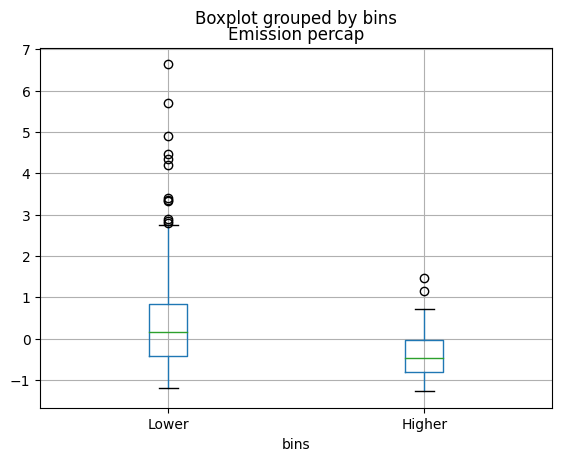

In [58]:
# Carefully check the results comparing to the chart in slides
val.boxplot(column=['Emission percap'], by='bins')


### Pre-classification

In [7]:
from sklearn.model_selection import train_test_split

# train/test set splitting
def train_test_split_on_sheet(sheet: pd.DataFrame, y=[], x=[], test_size=0.3):
    """Split train set and test set by specifying the column names"""
    arr_y = sheet[y].to_numpy()
    arr_x = sheet[x].to_numpy()

    # by default: X set comes first and then the Y set
    tx, vx, ty, vy = train_test_split(arr_x, arr_y, test_size=test_size)
    return tx, ty, vx, vy


# choose variables
xkeys = ['city_class', 'build_space', 'res_size', 'avg_age', 
        'res_income_percap', 'car_num', 'PV',  
        'if_single', 'if_single_kids', 'if_couple', 'if_couple_kids', 
        'if_single_elderly', 'if_couple_elderly', 'if_big_family', 
        'if_others']
ykeys = ['emits_per']
x, y, vx, vy = train_test_split_on_sheet(scaled, y=ykeys, x=xkeys)


### Build classifier

In [8]:
from sklearn import linear_model

# Linear model
linear = linear_model.LinearRegression()

# Lasso model
lasso = linear_model.Lasso(alpha=0.0001)


### Model evaluation

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# validate the performance of LR model
# to build a linear model with a, b (coef and intercept)
lr = linear.fit(x, y)
a, b = lr.coef_, lr.intercept_
py = lr.predict(x)
pvy = lr.predict(vx)

# evaluation on the train set
mse =  mean_squared_error(y, py)
r2 = r2_score(y, py)
print(f'Train set: MSE: {mse}, R2: {r2}')

# evaluation on the test set
mse =  mean_squared_error(vy, pvy)
r2 = r2_score(vy, pvy)
print(f'Test set: MSE: {mse}, R2: {r2}')


Train set: MSE: 0.567147790751397, R2: 0.407786134191753
Test set: MSE: 0.7250049286373441, R2: 0.339613420022723


In [10]:
# to validate the performance of LASSO model 
la = lasso.fit(x, y)
py = la.predict(x)
pvy = la.predict(vx)

# validate the performance of LR model
mse =  mean_squared_error(y, py)
r2 = r2_score(y, py)
print(f'Train set: MSE: {mse}, R2: {r2}')

# evaluation on the test set
mse =  mean_squared_error(vy, pvy)
r2 = r2_score(vy, pvy)
print(f'Test set: MSE: {mse}, R2: {r2}')



Train set: MSE: 0.5671523304472192, R2: 0.407781393856242
Test set: MSE: 0.7249922851055385, R2: 0.33962493665991844


### Much stronger model: xgboost


In [11]:
from xgboost import XGBRegressor

# use much stronger regressor from XGBoost toolkit
# Note: params in XGBRegressor control the performance!
model = XGBRegressor(n_estimators=200, max_depth=1, subsample=0.7)
model.fit(x, y)

py = model.predict(x)
pvy = model.predict(vx)
mse =  mean_squared_error(y, py)
r2 = r2_score(y, py)
print(f'Train set: MSE: {mse}, R2: {r2}')

mse =  mean_squared_error(vy, pvy)
r2 = r2_score(vy, pvy)
print(f'Test set: MSE: {mse}, R2: {r2}')


Train set: MSE: 0.4706814131174318, R2: 0.508516009809254
Test set: MSE: 0.7554274040238085, R2: 0.3119024436122997


### Visualization

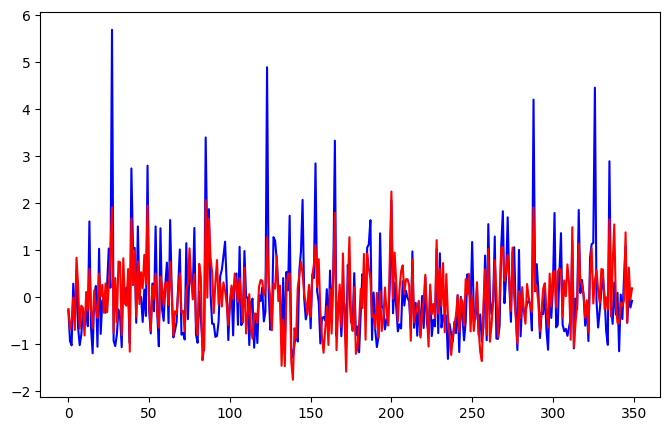

In [12]:
# create a canvas
fig = plt.figure(figsize=(8,5))

x_ = range(len(y))
plt.plot(x_, y.flatten(), 'b')  # vis the raw value of Y
plt.plot(x_, py.flatten(), 'r')  # vis the predicted value of Y
plt.show()


### Model explanability

In [13]:
import shap

# explanability of weak models, using the coefs
print("Model coefficients:\n")
for i in range(len(xkeys)):
    print(xkeys[i], "=", lr.coef_[0, i].round(5))


/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model coefficients:

city_class = 0.12023
build_space = 0.28827
res_size = -0.19114
avg_age = 0.00181
res_income_percap = 0.02447
car_num = 0.39203
PV = 0.28434
if_single = 0.54756
if_single_kids = -0.18923
if_couple = -0.05188
if_couple_kids = -0.2605
if_single_elderly = 0.63886
if_couple_elderly = -0.07158
if_big_family = -0.30613
if_others = -0.30709


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

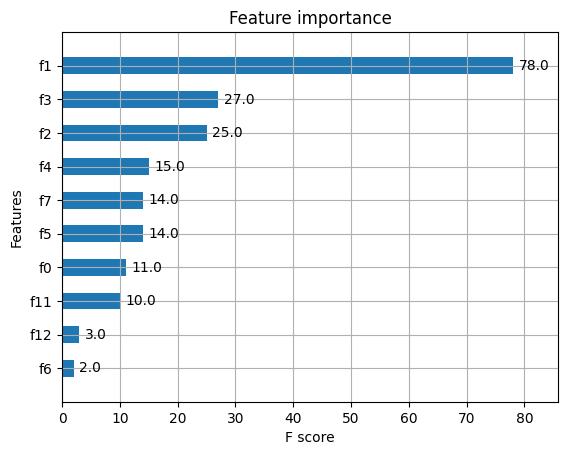

In [33]:
# show the importance in XGBoost model

import xgboost

xgboost.plot_importance(model, height=.5, max_num_features=10)

The features shown in the importance chart are as followed:
```python

['build_space', 
 'avg_age', 
 'res_size', 
 'res_income_percap', 
 'if_single', 'car_num', 
 'city_class', 
 'if_single_elderly', 
 'if_couple_elderly', 
 'PV']
```

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


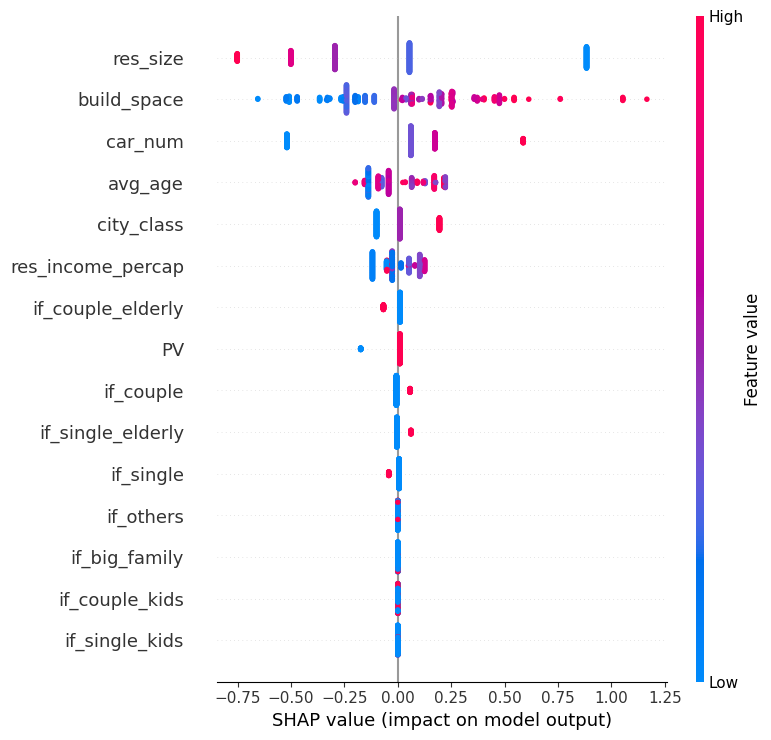

In [15]:
# explanability using shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x, feature_names=xkeys)


SHAP (Shapley additive explanations) used the classic theory Shapley value to combining the optimal scoring with partial explanation from gaming theory. It evaluates each feature's contribution in the final output through a fair collaboration. 

If you'd like to read more explanation about SHAP values, please visit: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Scatter%20Density%20vs.%20Violin%20Plot%20Comparison.html#Scatter-Density-vs.-Violin-Plot 

### Additional execrises

How to optimise the models?